In [44]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
# Kaggle Contest on African waterpump data set, 3 classifier problem

In [20]:
%%capture


# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [21]:


train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [22]:
train.head()

target = 'status_group'
features = ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [23]:
#Spliting features and target variable 'Status'
X = train[features]
y = train[target]

from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.35)

In [24]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X


In [25]:
#Data Norm
train = wrangle(X_train)
val = wrangle(X_val)
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
39946,500.0,Unicef,1469.0,DWE,34.716844,-8.840430,Kwa Saimon Kivinge,0,Rufiji,Magofu,Iringa,11,4,Njombe,Wanging'ombe,75.0,True,GeoData Consultants Ltd,WUA,wanging'ombe supply scheme,True,1978.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,False,False,False,False,False,2011,3,29,33.0,False
53540,500.0,Government Of Tanzania,1469.0,DWE,38.384069,-4.832051,Kwa Mzee Kisamvu,47,Pangani,Mamba,Tanga,4,1,Lushoto,Mamba,1.0,True,GeoData Consultants Ltd,VWC,Nywelo streem,True,1988.0,gravity,gravity,gravity,vwc,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,False,False,False,2011,3,27,23.0,False
13853,0.0,China Government,284.0,CHINA,38.561841,-11.134596,Kwa Mtuta,0,Ruvuma / Southern Coast,Msufini,Mtwara,90,63,Nanyumbu,Makonona,89.0,True,GeoData Consultants Ltd,VWC,NaN,True,NaN,other,other,other,vwc,user-group,never pay,coloured,colored,seasonal,shallow well,shallow well,groundwater,other,other,False,False,True,False,False,2013,1,30,NaN,True
48649,0.0,Government Of Tanzania,178.0,DWE,38.697766,-5.132638,Shuleni,0,Pangani,Kwemware,Tanga,4,3,Muheza,Nkumba,800.0,True,GeoData Consultants Ltd,VWC,Ufinga river,False,2004.0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe,False,False,False,False,False,2011,3,19,7.0,False
17812,0.0,Hesawa,NaN,DWE,31.203914,-2.906218,Kisimani,0,Lake Tanganyika,Lusahunga Kati,Kagera,18,4,Biharamulo,Lusahunga,NaN,True,GeoData Consultants Ltd,VWC,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,dry,shallow well,shallow well,groundwater,other,other,False,False,True,True,True,2011,7,13,NaN,True


In [26]:
type(X_train)

pandas.core.frame.DataFrame

In [27]:
#Development of a baseline
baseline_acc = y_train.where(y_train == 'functional').value_counts().sum() / len(y_train)
print('Baseline', baseline_acc)

Baseline 0.5444703444703445


In [28]:
#Creation of pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42, n_jobs=-1, min_samples_leaf= 5, )
)


In [42]:
#Testing training and validation scores of Model
pipeline.fit(X_train, y_train)
print('Train Acc', pipeline.score(X_train,y_train))
#prediction off X val
y_pred = pipeline.predict(X_val)
print('Val Acc', pipeline.score(X_val,y_val))




/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Train Acc 0.8777518777518778
Val Acc 0.8055315055315055
['non functional' 'non functional' 'functional' ... 'functional'
 'functional needs repair' 'non functional']


In [30]:
#import X Test features
X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id')

#Editing and checking format for Kaggle Submission
X_test['status_group'] = (pipeline.predict(X_test))
submission = X_test['status_group']
submission.value_counts()

functional                 9062
non functional             4904
functional needs repair     392
Name: status_group, dtype: int64

In [31]:
submission.to_csv(r'C:\Users\mikec\Documents\Lambda', index= True,  header = True)
print(submission)

id
50785        functional
51630        functional
17168        functional
45559    non functional
49871        functional
              ...      
39307    non functional
18990        functional
28749        functional
33492        functional
68707    non functional
Name: status_group, Length: 14358, dtype: object


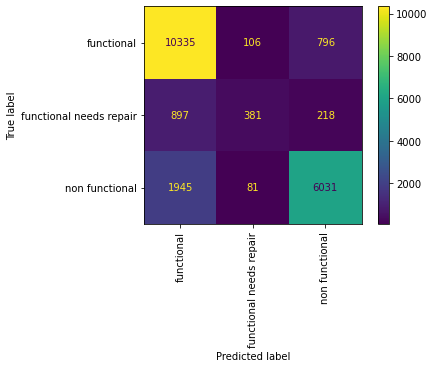

In [36]:
#model analysis 
cm = plot_confusion_matrix(pipeline, X_val, y_val,values_format='.0f', xticks_rotation='vertical' );

In [45]:

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.92      0.85     11237
functional needs repair       0.67      0.25      0.37      1496
         non functional       0.86      0.75      0.80      8057

               accuracy                           0.81     20790
              macro avg       0.77      0.64      0.67     20790
           weighted avg       0.80      0.81      0.79     20790

